In [1]:
from diff_predictor import data_process, predxgboost
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

Using current directory for loading/saving: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
To change current directory, call diff_predictor.core.change_dir(...)


In [2]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

In [3]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [20]:
age_feature_path = workbookDir + '/data/raw_data_age/'
age_feature_filelist = [f for f in listdir(age_feature_path) if isfile(join(age_feature_path, f)) and 'feat' in f]
print(len(age_feature_filelist))

age_msd_path = workbookDir + '/raw_data_age/'
age_msd_filelist = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd' in f]
print(len(age_msd_filelist))

region_dataset_path = workbookDir + '/data/region_feature_folder/'
region_filelist = [f for f in listdir(region_dataset_path) if isfile(join(region_dataset_path, f)) and 'feat' in f]
print(len(region_filelist))

treatment_dataset_path = workbookDir + '/data/ecm_feature_folder/'
treatment_filelist = [f for f in listdir(treatment_dataset_path) if isfile(join(treatment_dataset_path, f))]# and 'feat' in f]
print(len(treatment_filelist))

75
74
38
180


In [21]:
treatment_filelist

['msd_HYase_brain_2_slice_3_vid_4.csv',
 'msd_HYase_brain_3_slice_3_vid_2.csv',
 'msd_ChABC_brain_3_slice_2_vid_4.csv',
 'msd_ChABC_brain_2_slice_2_vid_2.csv',
 'msd_HYase_brain_1_slice_2_vid_2.csv',
 'msd_HYase_brain_4_slice_2_vid_1.csv',
 'msd_NT_brain_4_slice_3_vid_5.csv',
 'msd_ChABC_brain_1_slice_3_vid_4.csv',
 'msd_ChABC_brain_1_slice_3_vid_5.csv',
 'msd_NT_brain_4_slice_3_vid_4.csv',
 'msd_HYase_brain_1_slice_2_vid_3.csv',
 'msd_ChABC_brain_3_slice_2_vid_5.csv',
 'msd_ChABC_brain_2_slice_2_vid_3.csv',
 'msd_HYase_brain_2_slice_3_vid_5.csv',
 'msd_HYase_brain_3_slice_3_vid_3.csv',
 'msd_NT_brain_2_slice_2_vid_1.csv',
 'msd_NT_brain_3_slice_2_vid_5.csv',
 'msd_NT_brain_2_slice_2_vid_3.csv',
 'msd_HYase_brain_3_slice_3_vid_1.csv',
 'msd_ChABC_brain_2_slice_2_vid_1.csv',
 'msd_ChABC_brain_4_slice_3_vid_4.csv',
 'msd_NT_brain_1_slice_3_vid_5.csv',
 'msd_HYase_brain_1_slice_2_vid_1.csv',
 'msd_HYase_brain_4_slice_2_vid_2.csv',
 'msd_HYase_brain_4_slice_2_vid_3.csv',
 'msd_NT_brain_1_s

# Deep dive into Age Dataset

In [5]:
fstats_tot_age = data_process.generate_fullstats(age_feature_path, age_feature_filelist, ['P14', 'P35', 'P70'], 'age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P35_brain_2_slice_1_vid_4.csv size: (878, 91)
Adding file features_P35_brain_2_slice_1_vid_5.csv size: (467, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P35_brain_2_slice_1_vid_2.csv size: (833, 91)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P35_brain_2_slice_1_vid_3.csv size: (1017, 91)
A

In [6]:
fstats_tot_age = pd.DataFrame()
total_particles_count = 0
subset_particles_count = 0

frame_counter = 0

for i in range(len(age_feature_filelist)):
    df_features = pd.read_csv(age_feature_path + age_feature_filelist[i])
    file_name = age_feature_filelist[i]
    targets = ['P14', 'P35', 'P70']
    if any(substring in file_name for substring in targets):
        file_indicator = file_name[8:] # grabs the unique part of the file name only
        msd_filename = 'msd' + file_indicator
        target = file_name[9:12]

        features_df = pd.read_csv(age_feature_path + file_name)
        msd_df = pd.read_csv(age_msd_path + msd_filename)


        msd_df['Track_ID'] = msd_df['Track_ID'] + frame_counter
        # Remove particles that are in frame less than one second
        cutoff_df = msd_df[(msd_df['Frame'] == 16) & (msd_df['MSDs'].notna())]
        msd_df = msd_df[msd_df['Track_ID'].isin(set(cutoff_df['Track_ID'].unique()))]
        features_subset_df = features_df[features_df['Track_ID'].isin(set(msd_df['Track_ID'].unique()))]
        features_df['age'] = pd.Series(features_df.shape[0]*[target], index=features_df.index)
        
        features_df['Track_ID'] = features_df['Track_ID'] + frame_counter
        fstats_tot_age = fstats_tot_age.append(features_df)
        total_particles_count += len(features_df)
        subset_particles_count += len(features_subset_df)

In [6]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [10]:
fstats_tot_age

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,Mean convex_hull,Std convex_hull,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression
0,0,0.0,0.300022,1.466714,1.827982,0.831748,0.214532,0.234618,1.377828,0.274220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0.320179,34.234700,1.986628,0.871043,0.185748,0.268897,1.844000,0.457701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,1.724717,0.283085,3.071816,0.997034,0.027251,0.594843,5.022024,0.800877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,4.628234,0.000021,1.718922,0.786380,0.244962,0.203225,2.448351,0.591562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,1.447265,0.054312,2.213652,0.999969,0.002783,0.682137,15.441644,0.935240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,2483,2483.0,1.244407,3.097007,3.828334,0.190884,0.626005,0.026808,1.131339,0.116092,...,0.0,0.0,0.0,0.0,61677.926158,58576.689529,2167.685012,28.870567,0.055679,0.033333
2484,2484,2484.0,0.856812,38.059204,2.305006,0.243213,0.582611,0.035397,1.043384,0.041580,...,0.0,0.0,0.0,0.0,66908.222792,94312.052098,2102.733497,68.414051,0.065985,0.038573
2485,2485,2485.0,1.597605,3.623832,1.973804,0.993101,0.041601,0.550453,3.903707,0.743833,...,0.0,0.0,0.0,0.0,71640.148011,50936.480673,1809.149543,47.453268,0.040552,0.030271
2486,2486,2486.0,NaN,NaN,1.543847,0.993614,0.040019,0.555130,5.186930,0.807208,...,0.0,0.0,0.0,0.0,40033.751497,27545.867242,2535.298450,19.129082,0.080715,0.028470


In [7]:
ecm = fstats_tot_age[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [12]:
ecm[target].unique()

array(['P70', 'P14', 'P35'], dtype=object)

## Here are the cutoffs for different motion types

### alpha > 1.25: Directed Motion
### 1.25 ≥ alpha ≥ 0.75: Normal Diffusion
### 0.75 > alpha: Anomalous Diffusion/Confined Diffusion

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


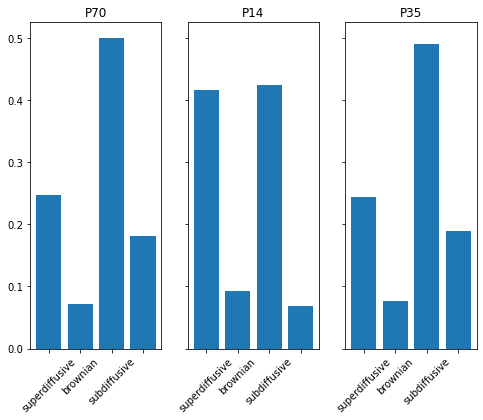

In [13]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(8,6))
#plt.ylim([0, 250])


for i, unique_class in enumerate(ecm[target].unique()):
    labels = ['superdiffusive', 'brownian', 'subdiffusive']
    percentages = []
    #bins=200
    # print(f'class {unique_class}')
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.1]
    percentages.append(len(directed_df)/len(df))
    # axes[i].hist(directed_df['alpha'], bins=bins)
    # print(len(directed_df))
    # print(f'directed diffusion %: {len(directed_df)/len(df)}')

    normal_df = df[(df['alpha'] <= 1.1) & (df['alpha'] >= 0.9)]
    percentages.append(len(normal_df)/len(df))
    # axes[i].hist(normal_df['alpha'], bins=bins)
    # print(len(normal_df))
    # print(f'normal diffusion %: {len(normal_df)/len(df)}')

    constrained_df = df[(df['alpha'] < 0.9) & (df['alpha'] > 0.1)]
    percentages.append(len(constrained_df)/len(df))
    # axes[i].hist(confined_df['alpha'], bins=bins)
    # print(len(confined_df))
    # print(f'confined diffusion %: {len(confined_df)/len(df)}')

    #hindered_df = df[(df['alpha'] <= 0.5) & (df['alpha'] > 0.2)]
    #percentages.append(len(hindered_df)/len(df))
    # axes[i].hist(hindered_df['alpha'], bins=bins)
    # print(f'hindered diffusion %: {len(hindered_df)/len(df)}')

    immobilized_df = df[(df['alpha'] <= 0.1)]
    percentages.append(len(immobilized_df)/len(df))
    # axes[i].hist(immobilized_df['alpha'], bins='doane')
    # print(f'immobilized diffusion %: {len(immobilized_df)/len(df)}')
    # print('')
    # axes[i].hist((df['alpha']), bins=40)
    #axes[i].vlines(([0.2, 0.5, 0.75, 1.25]), ymin=0, ymax=400, color='r')
    
    axes[i].bar(np.arange(len(percentages)), percentages)
    axes[i].set_xticklabels(labels)
    axes[i].set_xticks(np.arange(len(percentages)))
    axes[i].set_title(unique_class)

    #break

#for ax in axes:
    #ax.set_xscale('log')
    #ax.set_xlim([-1,1.4])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

P14
0.41551020408163264
0.0920408163265306
0.49244897959183676

P35
0.2438630708184814
0.07613154886004439
0.6800053803214742

P70
0.24770904925544102
0.07101947308132875
0.6812714776632303



(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

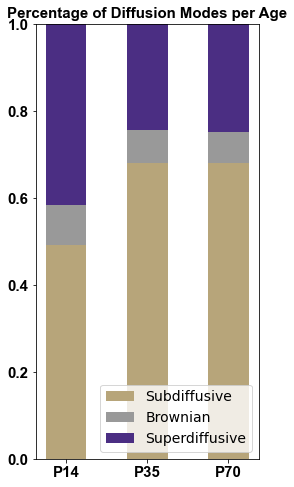

In [9]:
fig = plt.figure(figsize=(4,8))


labels = ecm[target].unique()
labels.sort()

directed_percent = np.zeros(len(labels))
normal_percent = np.zeros(len(labels))
constrained_percent = np.zeros(len(labels))
immobilized_percent = np.zeros(len(labels))

for i, unique_class in enumerate(labels):
    print(unique_class)
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.1]
    directed_percent[i] = (len(directed_df)/len(df))
    print(directed_percent[i])

    normal_df = df[(df['alpha'] <= 1.1) & (df['alpha'] >= 0.9)]
    normal_percent[i] = (len(normal_df)/len(df))
    print(normal_percent[i])
    
    constrained_df = df[(df['alpha'] < 0.9)]
    constrained_percent[i] = (len(constrained_df)/len(df))
    print(constrained_percent[i])
    print()
    
    #immobilized_df = df[(df['alpha'] <= 0.1)]
    #immobilized_percent[i] = (len(immobilized_df)/len(df))
    
    
#plt.bar(labels, immobilized_percent, color='r', label='immobilized')
bar_w = 0.5
plt.bar(labels, constrained_percent, label='Subdiffusive', width=bar_w, color='#b7a57a')
plt.bar(labels, normal_percent, bottom=constrained_percent+immobilized_percent, color='#999999', label='Brownian', width=bar_w)
plt.bar(labels, directed_percent, bottom=constrained_percent+immobilized_percent+normal_percent, color='#4b2e83', label='Superdiffusive', width=bar_w)
plt.ylim([0,1])
plt.legend(loc='lower right', fontsize=14)
plt.title('Percentage of Diffusion Modes per Age', fontsize=15, fontname='Arial', fontweight='bold')
plt.ylim([0,1])
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')

In [ ]:
mx = np.array(p70_ecm['alpha'])
x = np.sort(mx)
y = np.arange(1, len(mx)+1) / len(mx)
x, y = ecdf(mx)

In [ ]:
from matplotlib.ticker import PercentFormatter
bin_num = 500
fig, ax = plt.subplots(1,3)
ax[0].hist(np.array(p14_ecm['alpha']), bins=bin_num)
ax[1].hist(np.array(p35_ecm['alpha']), bins=bin_num)
ax[2].hist(np.array(p70_ecm['alpha']), bins=bin_num)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


In [ ]:
fig = plt.figure(figsize=(12,8))
for df in age_df_list:
    mx = np.array(df['alpha'])
    x = np.sort(mx)
    y = np.arange(1, len(mx)+1) / len(mx)
    plt.scatter(x, y, alpha=0.7, s=1, label=df['age'].unique()[0])
plt.vlines([directed], 0, 1, label='normal diffusion cutoff', linestyles='dashed')
plt.vlines(confined, 0, 1, label='confined diffusion cutoff', linestyles='dotted')
plt.xlim([0,3])
plt.legend()

In [35]:
# confined_ecm = ecm[ecm['alpha'] < 0.75]
# normal_ecm = ecm[(ecm['alpha'] >= 0.75) & (ecm['alpha'] <= 1.25)]
# directed_ecm = ecm[ecm['alpha'] > 1.25]

# directed_normal_ecm = ecm[ecm['alpha'] >= 0.75]
# directed_confined_ecm = ecm[(ecm['alpha'] > 1.25) | (ecm['alpha'] < 0.75)]
# normal_confined_ecm = ecm[ecm['alpha'] <= 1.25]

# no_immobil = ecm[ecm['alpha'] > 0.2]

In [11]:
def full_preprocess(ecm, balanced=True, target=None):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        #sampled_df = bal_ecm.sample(frac=0.5)
        sampled_df = data_process.bin_data(bal_ecm)
    else:
        sampled_df = data_process.bin_data(ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.8
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, X_train, X_test, y_train, y_test, le



In [84]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [10]:
confined_ecm = ecm[(ecm['alpha'] < 0.9) & (ecm['alpha'] > 0.1)]
normal_ecm = ecm[(ecm['alpha'] >= 0.9) & (ecm['alpha'] <= 1.1)]
directed_ecm = ecm[ecm['alpha'] > 1.1]

#hindered_ecm = ecm[(ecm['alpha'] > 0.2) & (ecm['alpha'] <= 0.5)]
#immobilized_ecm = ecm[ecm['alpha'] <= 0.1]

In [9]:
param = {'max_depth': 4, 'eta': 0.1, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}

In [16]:
target = 'age'

normal_acc_list = []
confined_acc_list = []
directed_acc_list = []
all_acc_list = []
#hindered_acc_list = []
#immobilized_acc_list = []
#no_imm_acc = []

normal_shap_list = []
confined_shap_list = []
directed_shap_list = []
all_shap_list = []
#immobilized_shap_list = []

def myfun(self=None):
    return model_bytearray
    
for i in range(50):
    print(i)
    # dtrain, dtest, dval, X_train, X_test, y_train, y_test = full_preprocess(normal_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # normal_acc_list.append(acc)
    #model_bytearray = booster.save_raw()[4:]
    #booster.save_raw = myfun
    #explainer = shap.TreeExplainer(booster)
    #shap_values = explainer.shap_values(X_test[features])
    #normal_shap_list.append(shap_values)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=76, verbose=False)
    directed_acc_list.append(acc)
    #model_bytearray = booster.save_raw()[4:]
    #booster.save_raw = myfun
    # explainer = shap.TreeExplainer(booster)
    # shap_values = explainer.shap_values(X_test[features])
    # directed_shap_list.append(shap_values)
    

    # dtrain, dtest, dval, X_train, X_test, y_train, y_test = full_preprocess(confined_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # confined_acc_list.append(acc)
    # model_bytearray = booster.save_raw()[4:]
    # booster.save_raw = myfun
    # explainer = shap.TreeExplainer(booster)
    # shap_values = explainer.shap_values(X_test[features])
    # confined_shap_list.append(shap_values)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(best_param_all, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)
    # model_bytearray = booster.save_raw()[4:]
    # booster.save_raw = myfun
    # explainer = shap.TreeExplainer(booster)
    # shap_values = explainer.shap_values(X_test[features])
    # all_shap_list.append(shap_values)

    # dtrain, dtest, dval, y_test= full_preprocess(hindered_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # hindered_acc_list.append(acc)

    # dtrain, dtest, dval, X_train, X_test, y_train, y_test = full_preprocess(immobilized_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # immobilized_acc_list.append(acc)
    # # model_bytearray = booster.save_raw()[4:]
    # # booster.save_raw = myfun
    # explainer = shap.TreeExplainer(booster)
    # shap_values = explainer.shap_values(X_test[features])
    # immobilized_shap_list.append(shap_values)

0
Ratio before data balance (P70:P14:P35) = 3460:2036:3626
Ratio after balance (P70:P14:P35) = 2036:2036:2036
Accuracy: 0.8673202614379085
Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900
Accuracy: 0.8643337819650068
1
Ratio before data balance (P70:P14:P35) = 3460:2036:3626
Ratio after balance (P70:P14:P35) = 2036:2036:2036
Accuracy: 0.8628872775214239
Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900
Accuracy: 0.8505376344086022
2
Ratio before data balance (P70:P14:P35) = 3460:2036:3626
Ratio after balance (P70:P14:P35) = 2036:2036:2036
Accuracy: 0.8842239185750637
Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900
Accuracy: 0.8584263544786278
3
Ratio before data balance (P70:P14:P35) = 3460:2036:3626
Ratio after balance (P70:P14:P35) = 2036:2036:2036
Accuracy: 0.8624511082138201
Ratio before data balance (

In [23]:
age_dict = {#'confined_acc': np.array(confined_acc_list),
                  'directed_acc': np.array(directed_acc_list),
                  #'normal_acc': np.array(normal_acc_list),
                  #'hindered_acc': np.array(hindered_acc_list),
                  #'immobilized_acc': np.array(immobilized_acc_list),
                  'all_modes_acc': np.array(all_acc_list)
                    }
age_result_df = pd.DataFrame.from_dict(age_dict)
age_result_df.to_csv('age_accuracies_v5.csv', index=False)


NameError: name 'directed_acc_list' is not defined

In [21]:
age_result_df = pd.read_csv('age_accuracies_v4.csv')

In [13]:
age_result_df.head()

,confined_acc,directed_acc,normal_acc,all_modes_acc
0,0.855657,0.856138,0.847761,0.852525
1,0.835506,0.874428,0.870317,0.853352
2,0.826359,0.855063,0.853448,0.861386
3,0.830798,0.859365,0.879213,0.865551
4,0.833755,0.861426,0.873199,0.841256


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

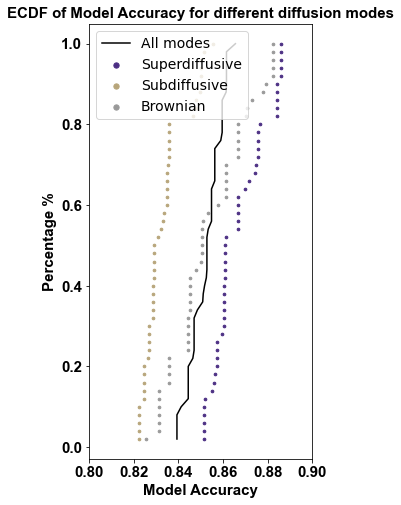

In [25]:
plt.figure(figsize=(4,8))
conf_x, conf_y = ecdf(np.array(age_result_df['confined_acc']))
dir_x, dir_y = ecdf(np.array(age_result_df['directed_acc']))
norm_x, norm_y = ecdf(np.array(age_result_df['normal_acc']))
all_x, all_y = ecdf(np.array(age_result_df['all_modes_acc']))
#hind_x, hind_y = ecdf(np.array(hindered_acc_list))
#imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
#no_imm_x, no_imm_y = ecdf(np.array(no_imm_acc))
plt.scatter(dir_x, dir_y, label='Superdiffusive', s=7, c='#4b2e83')
plt.scatter(conf_x, conf_y, label='Subdiffusive', s=7, c='#b7a57a')
plt.scatter(norm_x, norm_y, label='Brownian', s=7, c='#999999')
plt.plot(all_x, all_y, label='All modes', c='k')
#plt.scatter(hind_x, hind_y, label='hindered', s=2)
#plt.scatter(imm_x, imm_y, label='immobilized', s=2)
#plt.scatter(no_imm_x, no_imm_y, label='no immobilized points', s=0.5)
plt.legend(loc='upper left', markerscale=2.0, fontsize=14)
plt.xlabel('Model Accuracy', fontsize=15, fontname='Arial', fontweight='bold')
plt.ylabel('Percentage %', fontsize=15, fontname='Arial', fontweight='bold')
plt.title('ECDF of Model Accuracy for different diffusion modes', fontsize=15, fontname='Arial', fontweight='bold')
plt.xlim([0.8, 0.9])
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')

(0.5, 1.0)

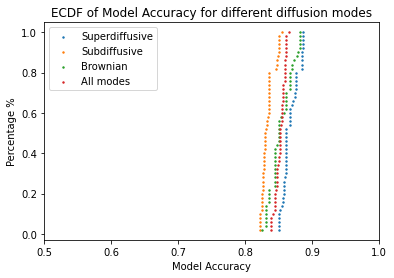

In [46]:
plt.figure()
conf_x, conf_y = ecdf(np.array(confined_acc_list))
dir_x, dir_y = ecdf(np.array(directed_acc_list))
norm_x, norm_y = ecdf(np.array(normal_acc_list))
all_x, all_y = ecdf(np.array(all_acc_list))
#hind_x, hind_y = ecdf(np.array(hindered_acc_list))
#imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
#no_imm_x, no_imm_y = ecdf(np.array(no_imm_acc))
plt.scatter(dir_x, dir_y, label='Superdiffusive', s=2)
plt.scatter(conf_x, conf_y, label='Subdiffusive', s=2)
plt.scatter(norm_x, norm_y, label='Brownian', s=2)
plt.scatter(all_x, all_y, label='All modes', s=2)
#plt.scatter(hind_x, hind_y, label='hindered', s=2)
#plt.scatter(imm_x, imm_y, label='immobilized', s=2)
#plt.scatter(no_imm_x, no_imm_y, label='no immobilized points', s=0.5)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')
plt.xlim([0.5, 1])

In [ ]:
plt.scatter(dir_x, dir_y, label='directed')

In [ ]:
directed_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(directed_ecm, balanced=True)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    directed_acc_list.append(acc)

In [ ]:
all_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(ecm, balanced=True)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)

In [ ]:
normal_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(normal_ecm, balanced=True)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc_list.append(acc)

In [24]:
directed_ecm[target].unique()

array(['P70', 'P14', 'NT'], dtype=object)

In [15]:
param

{'max_depth': 3,
 'eta': 0.005,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 3,
 'silent': 'True',
 'gamma': 5,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss'}

In [39]:
dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, target=target)
(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(X_train=X_train, y_train=X_train['encoded_target'], features=features, init_params=param)

Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900
Using CV with subsample={0.6}, colsample_bytree={1.0}
New best param found: mlogloss = {0.3953631990723139}, boost_rounds = {1999}
Using CV with subsample={1.0}, colsample_bytree={0.9}
Using CV with subsample={0.6}, colsample_bytree={0.5}
Using CV with subsample={0.6}, colsample_bytree={0.9}
New best param found: mlogloss = {0.3949762539730819}, boost_rounds = {1999}
Using CV with subsample={1.0}, colsample_bytree={0.5}
Using CV with subsample={1.0}, colsample_bytree={1.0}
Using CV with max_depth={3}, min_child_weight={2}
New best param found: mlogloss = {0.39493800707170557}, boost_rounds = {1999}
Using CV with max_depth={5}, min_child_weight={10}
New best param found: mlogloss = {0.3872865434567713}, boost_rounds = {1709}
Using CV with max_depth={10}, min_child_weight={10}
Using CV with max_depth={3}, min_child_weight={0}
Using CV with max_depth={3}, min_child_weight={10}
Usi

In [40]:
print(best_param)
print(best_boost_rounds)
print(best_eval)

{'max_depth': 5, 'eta': 0.01, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss'}
804
0.3810867508174283


In [13]:
print(best_param)
print(best_boost_rounds)
print(best_eval)

{'max_depth': 9, 'eta': 0.1, 'min_child_weight': 10, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}
71
0.35992462385620916


In [14]:
best_param_all = {'max_depth': 4, 'eta': 0.1, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}

In [32]:
print(best_param)
print(best_boost_rounds)
print(best_eval)

{'max_depth': 4, 'eta': 0.1, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}
96
0.3628241111550633


In [33]:
best_model

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,1.007004,0.003072,1.016312,0.004001
1,0.930013,0.004457,0.948317,0.005094
2,0.859897,0.006046,0.884992,0.008344
3,0.801961,0.005926,0.834556,0.010563
4,0.752244,0.007335,0.791032,0.012776
...,...,...,...,...
92,0.122271,0.005689,0.363305,0.053571
93,0.121211,0.005602,0.363686,0.053641
94,0.120136,0.005571,0.363069,0.053599
95,0.119060,0.005469,0.362933,0.053397


In [37]:
directed_acc_list = []
all_acc_list = []
for i in range(100):

    print(i)
    dtrain, dtest, dval, X_train, y_test= full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds, verbose=False)
    all_acc_list.append(acc)

    print(i)
    dtrain, dtest, dval, X_train, y_test= full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds, verbose=False)
    directed_acc_list.append(acc)

0
Ratio before data balance (P70:P14:NT) = 13968:4900:14869
Ratio after balance (P70:P14:NT) = 4900:4900:4900
Accuracy: 0.84559221200649
0
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707
Accuracy: 0.8733974358974359
1
Ratio before data balance (P70:P14:NT) = 13968:4900:14869
Ratio after balance (P70:P14:NT) = 4900:4900:4900
Accuracy: 0.8458980044345898
1
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707
Accuracy: 0.8450039339103068
2
Ratio before data balance (P70:P14:NT) = 13968:4900:14869
Ratio after balance (P70:P14:NT) = 4900:4900:4900
Accuracy: 0.8512
2
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707
Accuracy: 0.8643439584877687
3
Ratio before data balance (P70:P14:NT) = 13968:4900:14869
Ratio after balance (P70:P14:NT) = 4900:4900:4900
Accuracy: 0.8359818388195233
3
Ratio before data balance (P70:P14:NT) = 2851

Text(0.5, 1.0, 'ECDF of Model Accuracy for different diffusion modes')

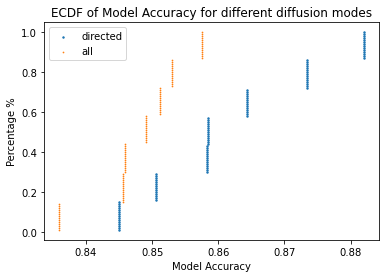

In [45]:
plt.figure()
dir_x, dir_y = ecdf(np.array(directed_acc_list))

no_imm_x, no_imm_y = ecdf(np.array(all_acc_list))
plt.scatter(dir_x, dir_y, label='directed', s=2)
#plt.hist(dir_x, bins=100)
plt.scatter(no_imm_x, no_imm_y, label='all', s=0.5)
#plt.hist(no_imm_x, bins=100)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')

# Deep dive into region data

In [12]:
fstats_tot_region = data_process.generate_fullstats(region_dataset_path, region_filelist, ['cortex', 'hippocampus', 'striatum'], 'region')

Adding file feat_NT_slice_2_striatum_vid_4.csv size: (10237, 67)
Adding file feat_NT_slice_2_striatum_vid_5.csv size: (13938, 67)
Adding file feat_NT_slice_1_striatum_vid_1.csv size: (2431, 67)
Adding file feat_NT_slice_2_cortex_vid_4.csv size: (1429, 67)
Adding file feat_NT_slice_1_striatum_vid_3.csv size: (1536, 67)
Adding file feat_NT_slice_1_cortex_vid_10.csv size: (4832, 67)
Adding file feat_NT_slice_1_striatum_vid_2.csv size: (2240, 67)
Adding file feat_NT_slice_2_cortex_vid_5.csv size: (2210, 67)
Adding file feat_NT_slice_2_cortex_vid_1.csv size: (1388, 67)
Adding file feat_NT_slice_2_hippocampus_vid_2.csv size: (46, 67)
Adding file feat_NT_slice_2_striatum_vid_2.csv size: (10500, 67)
Adding file feat_NT_slice_2_striatum_vid_3.csv size: (11355, 67)
Adding file feat_NT_slice_2_hippocampus_vid_3.csv size: (307, 67)
Adding file feat_NT_slice_2_cortex_vid_2.csv size: (1784, 67)
Adding file feat_NT_slice_1_cortex_vid_8.csv size: (1984, 67)
Adding file feat_NT_slice_1_striatum_vid_5.c

In [13]:
target = 'region'
ecm = fstats_tot_region[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(111118, 36)


(82209, 36)

cortex
0.3252541887440928
0.060539882571960475
0.6142059286839467

hippocampus
0.3809003279340157
0.08844281029514062
0.5306568617708437

striatum
0.2288189261319944
0.05597774460578098
0.7152033292622246



(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

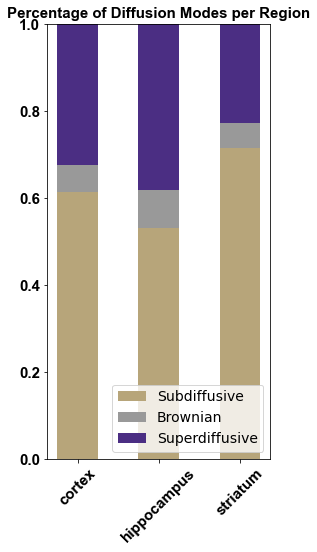

In [14]:
fig = plt.figure(figsize=(4,8))


labels = ecm[target].unique()
labels.sort()

directed_percent = np.zeros(len(labels))
normal_percent = np.zeros(len(labels))
constrained_percent = np.zeros(len(labels))
immobilized_percent = np.zeros(len(labels))

for i, unique_class in enumerate(labels):
    
    print(unique_class)
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.1]
    directed_percent[i] = (len(directed_df)/len(df))
    print(directed_percent[i])

    normal_df = df[(df['alpha'] <= 1.1) & (df['alpha'] >= 0.9)]
    normal_percent[i] = (len(normal_df)/len(df))
    print(normal_percent[i])
    
    constrained_df = df[(df['alpha'] < 0.9)]
    constrained_percent[i] = (len(constrained_df)/len(df))
    print(constrained_percent[i])
    print()
    
    #immobilized_df = df[(df['alpha'] <= 0.1)]
    #immobilized_percent[i] = (len(immobilized_df)/len(df))
    
    
#plt.bar(labels, immobilized_percent, color='r', label='immobilized')
bar_w = 0.5
plt.bar(labels, constrained_percent, color='#b7a57a', label='Subdiffusive', width=bar_w)
plt.bar(labels, normal_percent, bottom=constrained_percent+immobilized_percent, color='#999999', label='Brownian', width=bar_w)
plt.bar(labels, directed_percent, bottom=constrained_percent+immobilized_percent+normal_percent, color='#4b2e83', label='Superdiffusive', width=bar_w)
plt.ylim([0,1])
plt.xticks(rotation='45')
plt.legend(loc='lower right', fontsize=14)
plt.title('Percentage of Diffusion Modes per Region', fontsize=15, fontname='Arial', fontweight='bold')
plt.ylim([0,1])
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')

In [63]:
hippo_ecm = ecm[ecm[target] == 'hippocampus']
print(len(hippo_ecm))
thala_ecm = ecm[ecm[target] == 'thalamus']
print(len(thala_ecm))
gangl_ecm = ecm[ecm[target] == 'ganglia']
print(len(gangl_ecm))

cortex_ecm = ecm[ecm[target] == 'cortex']
print(len(cortex_ecm))

striat_ecm = ecm[ecm[target] == 'striatum']
print(len(striat_ecm))


10063
0
0
27932
44214


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


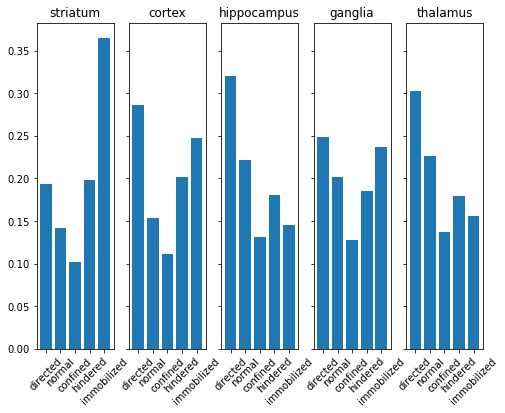

In [25]:
#age_df_list = [hippo_ecm, thala_ecm, gangl_ecm, cortex_ecm, striat_ecm]
fig, axes = plt.subplots(1,len(ecm[target].unique()), sharey=True, figsize=(8,6))
#plt.ylim([0, 250])


for i, unique_class in enumerate(ecm[target].unique()):
    labels = ['directed', 'normal', 'confined', 'hindered', 'immobilized']
    percentages = []
    #bins=200
    # print(f'class {unique_class}')
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.25]
    percentages.append(len(directed_df)/len(df))
    # axes[i].hist(directed_df['alpha'], bins=bins)
    # print(len(directed_df))
    # print(f'directed diffusion %: {len(directed_df)/len(df)}')

    normal_df = df[(df['alpha'] <= 1.25) & (df['alpha'] >= 0.75)]
    percentages.append(len(normal_df)/len(df))
    # axes[i].hist(normal_df['alpha'], bins=bins)
    # print(len(normal_df))
    # print(f'normal diffusion %: {len(normal_df)/len(df)}')

    confined_df = df[(df['alpha'] < 0.75) & (df['alpha'] > 0.5)]
    percentages.append(len(confined_df)/len(df))
    # axes[i].hist(confined_df['alpha'], bins=bins)
    # print(len(confined_df))
    # print(f'confined diffusion %: {len(confined_df)/len(df)}')

    hindered_df = df[(df['alpha'] <= 0.5) & (df['alpha'] > 0.2)]
    percentages.append(len(hindered_df)/len(df))
    # axes[i].hist(hindered_df['alpha'], bins=bins)
    # print(f'hindered diffusion %: {len(hindered_df)/len(df)}')

    immobilized_df = df[(df['alpha'] <= 0.2)]
    percentages.append(len(immobilized_df)/len(df))
    # axes[i].hist(immobilized_df['alpha'], bins='doane')
    # print(f'immobilized diffusion %: {len(immobilized_df)/len(df)}')
    # print('')
    # axes[i].hist((df['alpha']), bins=40)
    #axes[i].vlines(([0.2, 0.5, 0.75, 1.25]), ymin=0, ymax=400, color='r')
    
    axes[i].bar(np.arange(len(percentages)), percentages)
    axes[i].set_xticklabels(labels)
    axes[i].set_xticks(np.arange(len(percentages)))
    axes[i].set_title(unique_class)

    #break

#for ax in axes:
    #ax.set_xscale('log')
    #ax.set_xlim([-1,1.4])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [87]:
confined_ecm = ecm[(ecm['alpha'] < 0.9)]
normal_ecm = ecm[(ecm['alpha'] >= 0.9) & (ecm['alpha'] <= 1.1)]
directed_ecm = ecm[ecm['alpha'] > 1.1]

#hindered_ecm = ecm[(ecm['alpha'] > 0.2) & (ecm['alpha'] <= 0.5)]
#immobilized_ecm = ecm[ecm['alpha'] <= 0.1]

#best_ecm = ecm[(ecm['alpha'] > 1.25) | (ecm['alpha'] <= 0.2)]
#len(best_ecm)

In [89]:
target = 'region'

normal_acc_list = []
confined_acc_list = []
directed_acc_list = []
all_acc_list = []
#hindered_acc_list = []
immobilized_acc_list = []
for i in range(50):
    print(i)
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(normal_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc_list.append(acc)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    directed_acc_list.append(acc)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(confined_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    confined_acc_list.append(acc)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)

    # dtrain, dtest, dval, X_train, y_test = full_preprocess(hindered_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # hindered_acc_list.append(acc)

    # dtrain, dtest, dval, X_train, y_test = full_preprocess(immobilized_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # immobilized_acc_list.append(acc)

0
Ratio before data balance (striatum:cortex:hippocampus) = 2475:1691:890
Ratio after balance (striatum:cortex:hippocampus) = 890:890:890
Accuracy: 0.7575757575757576
Ratio before data balance (striatum:cortex:hippocampus) = 10117:9085:3833
Ratio after balance (striatum:cortex:hippocampus) = 3833:3833:3833
Accuracy: 0.8945386064030132
Ratio before data balance (striatum:cortex:hippocampus) = 31622:17156:5340
Ratio after balance (striatum:cortex:hippocampus) = 5340:5340:5340
Accuracy: 0.8759493670886076
Ratio before data balance (striatum:cortex:hippocampus) = 44214:27932:10063
Ratio after balance (striatum:cortex:hippocampus) = 10063:10063:10063
Accuracy: 0.8600525624178712
1
Ratio before data balance (striatum:cortex:hippocampus) = 2475:1691:890
Ratio after balance (striatum:cortex:hippocampus) = 890:890:890
Accuracy: 0.8837209302325582
Ratio before data balance (striatum:cortex:hippocampus) = 10117:9085:3833
Ratio after balance (striatum:cortex:hippocampus) = 3833:3833:3833
Accuracy:

In [29]:
target = 'region'
dir_ecm_acc = []
all_acc_list = []
for i in range(50):
    print(i)
    dtrain, dtest, dval, X_train, y_test= full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    dir_ecm_acc.append(acc)

    dtrain, dtest, dval, X_train, y_test= full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(best_param_all, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)

0
Ratio before data balance (striatum:cortex:hippocampus) = 10117:9085:3833
Ratio after balance (striatum:cortex:hippocampus) = 3833:3833:3833


ValueError: too many values to unpack (expected 5)

(0.85, 0.95)

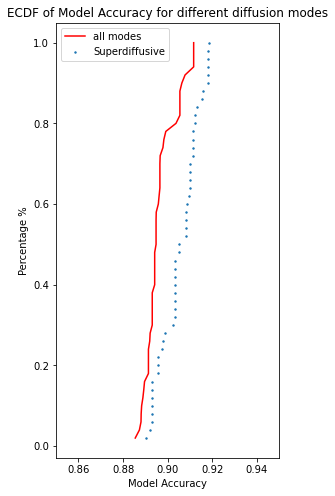

In [33]:
plt.figure(figsize=(4,8))
#conf_x, conf_y = ecdf(np.array(confined_acc_list))
dir_x, dir_y = ecdf(np.array(directed_acc_list))
#norm_x, norm_y = ecdf(np.array(normal_acc_list))
all_x, all_y = ecdf(np.array(all_acc_list))
#hind_x, hind_y = ecdf(np.array(hindered_acc_list))
#imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
#best_x, best_y = ecdf(np.array(best_ecm_acc))
#no_norm_x, no_norm_y = ecdf(np.array(no_normal_acc))
plt.scatter(dir_x, dir_y, label='Superdiffusive', s=2)
#plt.scatter(conf_x, conf_y, label='Subdiffusive', s=2)
#plt.scatter(norm_x, norm_y, label='Brownian', s=2)
plt.plot(all_x, all_y, label='all modes', c='r')
#plt.scatter(hind_x, hind_y, label='hindered', s=2)
#plt.scatter(imm_x, imm_y, label='immobilized', s=2)
#plt.scatter(no_norm_x, no_norm_y, label='no normal points', s=0.5)
#plt.scatter(best_x, best_y, label='top two', s=2)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')
plt.xlim([0.85, 0.95])

(0.8, 0.9)

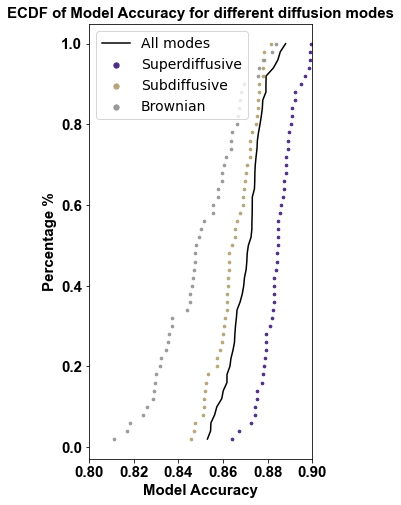

In [30]:
plt.figure(figsize=(4,8))
conf_x, conf_y = ecdf(np.array(region_result_df['confined_acc']))
dir_x, dir_y = ecdf(np.array(region_result_df['directed_acc']))
norm_x, norm_y = ecdf(np.array(region_result_df['normal_acc']))
all_x, all_y = ecdf(np.array(region_result_df['all_modes_acc']))
#hind_x, hind_y = ecdf(np.array(hindered_acc_list))
#imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
#no_imm_x, no_imm_y = ecdf(np.array(no_imm_acc))
plt.scatter(dir_x, dir_y, label='Superdiffusive', s=7, c='#4b2e83')
plt.scatter(conf_x, conf_y, label='Subdiffusive', s=7, c='#b7a57a')
plt.scatter(norm_x, norm_y, label='Brownian', s=7, c='#999999')
plt.plot(all_x, all_y, label='All modes', c='k')
#plt.scatter(hind_x, hind_y, label='hindered', s=2)
#plt.scatter(imm_x, imm_y, label='immobilized', s=2)
#plt.scatter(no_imm_x, no_imm_y, label='no immobilized points', s=0.5)
plt.legend(loc='upper left', markerscale=2.0, fontsize=14)
plt.xlabel('Model Accuracy', fontsize=15, fontname='Arial', fontweight='bold')
plt.ylabel('Percentage %', fontsize=15, fontname='Arial', fontweight='bold')
plt.title('ECDF of Model Accuracy for different diffusion modes', fontsize=15, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.xlim([0.8, 0.9])

In [90]:
region_dict = {'confined_acc': np.array(confined_acc_list),
                  'directed_acc': np.array(directed_acc_list),
                  'normal_acc': np.array(normal_acc_list),
                  #'hindered_acc': np.array(hindered_acc_list),
                  #'immobilized_acc': np.array(immobilized_acc_list),
                  'all_modes_acc': np.array(all_acc_list)
                    }
region_result_df = pd.DataFrame.from_dict(region_dict)
region_result_df.to_csv('region_accuracies_V3.csv', index=False)

In [27]:
region_result_df = pd.read_csv('region_accuracies_V2.csv')

In [28]:
region_result_df

,confined_acc,directed_acc,normal_acc,all_modes_acc
0,0.851578,0.879063,0.828909,0.861766
1,0.860207,0.888365,0.810937,0.872546
2,0.876188,0.885823,0.846039,0.857234
3,0.875987,0.884746,0.855607,0.853017
4,0.877689,0.879079,0.869501,0.872958
5,0.847445,0.882986,0.835714,0.865583
6,0.847178,0.887130,0.876093,0.875896
7,0.869180,0.888305,0.837278,0.856242
8,0.851880,0.888094,0.861314,0.877134
9,0.862814,0.875127,0.828829,0.861779


In [20]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 5,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [26]:
dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(directed_ecm, target=target)
(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(X_train=X_train, y_train=X_train['encoded_target'], features=features, init_params=param)

Ratio before data balance (striatum:cortex:hippocampus) = 10117:9085:3833
Ratio after balance (striatum:cortex:hippocampus) = 3833:3833:3833
Using CV with subsample={0.9}, colsample_bytree={0.7}
New best param found: mlogloss = {0.2455933219684246}, boost_rounds = {74}
Using CV with subsample={0.7}, colsample_bytree={0.5}
New best param found: mlogloss = {0.2441397752771246}, boost_rounds = {84}
Using CV with subsample={0.9}, colsample_bytree={0.6}
New best param found: mlogloss = {0.24349782028888145}, boost_rounds = {94}
Using CV with subsample={0.7}, colsample_bytree={0.6}
Using CV with subsample={0.9}, colsample_bytree={0.5}
Using CV with subsample={0.7}, colsample_bytree={0.7}
Using CV with max_depth={10}, min_child_weight={8}
Using CV with max_depth={4}, min_child_weight={10}
Using CV with max_depth={4}, min_child_weight={7}
Using CV with max_depth={7}, min_child_weight={0}
Using CV with max_depth={6}, min_child_weight={8}
Using CV with max_depth={6}, min_child_weight={7}
Using C

In [28]:
best_param

{'max_depth': 4,
 'eta': 0.2,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 3,
 'silent': 'True',
 'gamma': 0,
 'subsample': 0.9,
 'colsample_bytree': 0.5,
 'eval_metric': 'mlogloss'}

In [27]:
best_param_all_ = {'max_depth': 4,
 'eta': 0.005,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 5,
 'silent': 'True',
 'gamma': 5,
 'subsample': 0.6,
 'colsample_bytree': 0.7,
 'eval_metric': 'mlogloss'}

# Deep dive into treatment data

In [22]:
fstats_tot_treatment = data_process.generate_fullstats(treatment_dataset_path, treatment_filelist, ['NT', 'ChABC'], 'treatment')

Adding file msd_ChABC_brain_3_slice_2_vid_4.csv size: (1240, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_2.csv size: (714, 67)
Adding file msd_NT_brain_4_slice_3_vid_5.csv size: (1876, 67)
Adding file msd_ChABC_brain_1_slice_3_vid_4.csv size: (1594, 67)
Adding file msd_ChABC_brain_1_slice_3_vid_5.csv size: (1212, 67)
Adding file msd_NT_brain_4_slice_3_vid_4.csv size: (2106, 67)
Adding file msd_ChABC_brain_3_slice_2_vid_5.csv size: (2084, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_3.csv size: (1336, 67)
Adding file msd_NT_brain_2_slice_2_vid_1.csv size: (2488, 67)
Adding file msd_NT_brain_3_slice_2_vid_5.csv size: (893, 67)
Adding file msd_NT_brain_2_slice_2_vid_3.csv size: (1735, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_1.csv size: (1788, 67)
Adding file msd_ChABC_brain_4_slice_3_vid_4.csv size: (2689, 67)
Adding file msd_NT_brain_1_slice_3_vid_5.csv size: (1009, 67)
Adding file msd_NT_brain_1_slice_3_vid_4.csv size: (1446, 67)
Adding file msd_ChABC_brain_4_slice_3_vid_5.csv 

In [23]:
target = 'treatment'
ecm = fstats_tot_treatment[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(142453, 36)


(117505, 36)

ChABC
0.306481154744501
0.08445497471055771
0.6090638705449413

NT
0.24630134151808808
0.07516294789116115
0.6785357105907508



(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

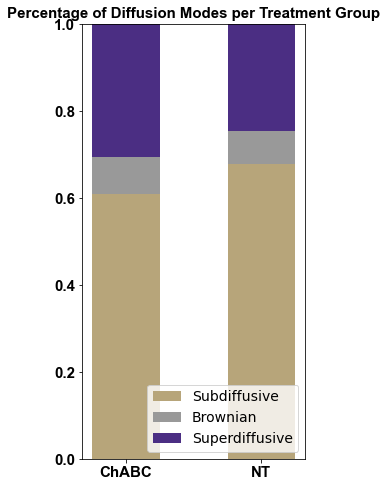

In [24]:
fig = plt.figure(figsize=(4,8))


labels = ecm[target].unique()

directed_percent = np.zeros(len(labels))
normal_percent = np.zeros(len(labels))
constrained_percent = np.zeros(len(labels))
immobilized_percent = np.zeros(len(labels))

for i, unique_class in enumerate(ecm[target].unique()):
    
    print(unique_class)
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.1]
    directed_percent[i] = (len(directed_df)/len(df))
    print(directed_percent[i])

    normal_df = df[(df['alpha'] <= 1.1) & (df['alpha'] >= 0.9)]
    normal_percent[i] = (len(normal_df)/len(df))
    print(normal_percent[i])
    
    constrained_df = df[(df['alpha'] < 0.9)]
    constrained_percent[i] = (len(constrained_df)/len(df))
    print(constrained_percent[i])
    print()
    
    #immobilized_df = df[(df['alpha'] <= 0.1)]
    #immobilized_percent[i] = (len(immobilized_df)/len(df))
    
    
#plt.bar(labels, immobilized_percent, color='r', label='immobilized')
bar_w = 0.5
plt.bar(labels, constrained_percent, color='#b7a57a', label='Subdiffusive', width=bar_w)
plt.bar(labels, normal_percent, bottom=constrained_percent+immobilized_percent, color='#999999', label='Brownian', width=bar_w)
plt.bar(labels, directed_percent, bottom=constrained_percent+immobilized_percent+normal_percent, color='#4b2e83', label='Superdiffusive', width=bar_w)
plt.ylim([0,1])
plt.legend(loc='lower right', fontsize=14)
plt.title('Percentage of Diffusion Modes per Treatment Group', fontsize=15, fontname='Arial', fontweight='bold')
plt.ylim([0,1])
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


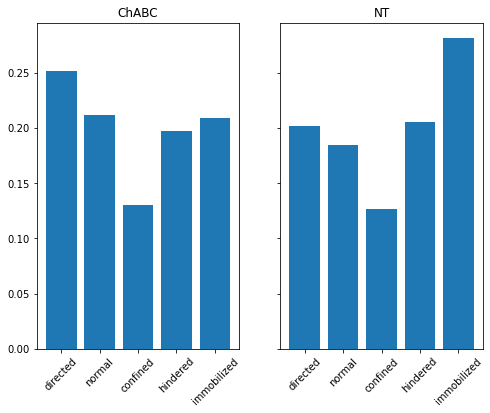

In [28]:
#age_df_list = [hippo_ecm, thala_ecm, gangl_ecm, cortex_ecm, striat_ecm]
fig, axes = plt.subplots(1,len(ecm[target].unique()), sharey=True, figsize=(8,6))
#plt.ylim([0, 250])


for i, unique_class in enumerate(ecm[target].unique()):
    labels = ['directed', 'normal', 'confined', 'hindered', 'immobilized']
    percentages = []
    #bins=200
    # print(f'class {unique_class}')
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.25]
    percentages.append(len(directed_df)/len(df))
    # axes[i].hist(directed_df['alpha'], bins=bins)
    # print(len(directed_df))
    # print(f'directed diffusion %: {len(directed_df)/len(df)}')

    normal_df = df[(df['alpha'] <= 1.25) & (df['alpha'] >= 0.75)]
    percentages.append(len(normal_df)/len(df))
    # axes[i].hist(normal_df['alpha'], bins=bins)
    # print(len(normal_df))
    # print(f'normal diffusion %: {len(normal_df)/len(df)}')

    confined_df = df[(df['alpha'] < 0.75) & (df['alpha'] > 0.5)]
    percentages.append(len(confined_df)/len(df))
    # axes[i].hist(confined_df['alpha'], bins=bins)
    # print(len(confined_df))
    # print(f'confined diffusion %: {len(confined_df)/len(df)}')

    hindered_df = df[(df['alpha'] <= 0.5) & (df['alpha'] > 0.2)]
    percentages.append(len(hindered_df)/len(df))
    # axes[i].hist(hindered_df['alpha'], bins=bins)
    # print(f'hindered diffusion %: {len(hindered_df)/len(df)}')

    immobilized_df = df[(df['alpha'] <= 0.2)]
    percentages.append(len(immobilized_df)/len(df))
    # axes[i].hist(immobilized_df['alpha'], bins='doane')
    # print(f'immobilized diffusion %: {len(immobilized_df)/len(df)}')
    # print('')
    # axes[i].hist((df['alpha']), bins=40)
    #axes[i].vlines(([0.2, 0.5, 0.75, 1.25]), ymin=0, ymax=400, color='r')
    
    axes[i].bar(np.arange(len(percentages)), percentages)
    axes[i].set_xticklabels(labels)
    axes[i].set_xticks(np.arange(len(percentages)))
    axes[i].set_title(unique_class)

    #break

#for ax in axes:
    #ax.set_xscale('log')
    #ax.set_xlim([-1,1.4])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [95]:
confined_ecm = ecm[(ecm['alpha'] < 0.9)]
normal_ecm = ecm[(ecm['alpha'] >= 0.9) & (ecm['alpha'] <= 1.1)]
directed_ecm = ecm[ecm['alpha'] > 1.1]

#hindered_ecm = ecm[(ecm['alpha'] > 0.2) & (ecm['alpha'] <= 0.5)]
#immobilized_ecm = ecm[ecm['alpha'] <= 0.1]

In [62]:
ecm

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean trappedness,Mean efficiency,Mean straightness,Mean MSD_ratio,Mean Deff1,Mean Deff2,treatment,Track_ID,X,Y
0,1.878565e-01,36.071627,2.338124,0.951962,0.110937,0.385995,2.526975,0.604270,0.064001,1.725938,...,-0.191065,0.360522,0.138351,0.694635,3.536721,3.035804,ChABC,0.0,444.129605,1570.720635
1,1.504078e+00,1.667101,2.777049,0.776931,0.251033,0.197486,1.991500,0.497866,0.039482,1.471273,...,-0.211247,1.320791,0.268845,0.315698,5.647557,NaN,ChABC,1.0,66.895831,1777.592412
2,2.049495e-01,16.349098,1.724795,0.116739,0.700484,0.015633,1.089697,0.082314,0.139215,1.996951,...,-0.188162,0.742677,0.301446,0.406357,3.744574,NaN,ChABC,2.0,36.114584,1546.653855
3,1.701015e-01,29.558679,3.503406,0.603727,0.354250,0.120682,1.547399,0.353754,0.088802,2.370751,...,-0.211247,1.320791,0.268845,0.315698,5.647557,NaN,ChABC,3.0,67.596184,1788.798383
4,1.396299e+00,1.613972,5.018309,0.230795,0.592432,0.033301,1.249634,0.199766,0.064811,1.765678,...,-0.199194,0.594937,0.208252,0.227974,5.151850,2.861776,ChABC,4.0,146.227782,1971.247294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142448,4.412228e-08,22.958618,4.774325,0.452890,0.442129,0.077769,1.770376,0.435148,0.230416,2.002749,...,-0.189579,0.831625,0.222022,1.094731,9.697386,NaN,ChABC,1220.0,1939.338618,329.347986
142449,2.910524e-01,2.325074,2.713067,0.665111,0.318745,0.143217,1.041777,0.040102,0.164625,2.067790,...,-0.196916,0.942970,0.197118,0.405977,4.543390,NaN,ChABC,1221.0,1879.016949,60.218140
142450,1.602942e-07,48.960384,3.015880,0.484227,0.423485,0.085573,1.800726,0.444668,0.121160,2.080707,...,-0.189579,0.831625,0.222022,1.094731,9.697386,NaN,ChABC,1222.0,1940.240130,318.894107
142451,1.272598e+00,1.339043,2.091200,0.950226,0.112974,0.382131,2.373707,0.578718,0.074625,1.527581,...,-0.196916,0.942970,0.197118,0.405977,4.543390,NaN,ChABC,1223.0,1869.137900,48.498968


In [103]:
target = 'treatment'

normal_acc_list = []
confined_acc_list = []
directed_acc_list = []
all_acc_list = []
#hindered_acc_list = []
#immobilized_acc_list = []
for i in range(50):
    print(i)
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(normal_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc_list.append(acc)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    directed_acc_list.append(acc)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(confined_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    confined_acc_list.append(acc)

    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)

    # dtrain, dtest, dval, y_test= full_preprocess(hindered_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # hindered_acc_list.append(acc)

    # dtrain, dtest, dval, x_train, y_test= full_preprocess(immobilized_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # immobilized_acc_list.append(acc)

0
Ratio before data balance (ChABC:NT) = 5026:4359
Ratio after balance (ChABC:NT) = 4359:4359
Accuracy: 0.6947809878844362
Ratio before data balance (ChABC:NT) = 18239:14284
Ratio after balance (ChABC:NT) = 14284:14284
Accuracy: 0.6938403255226603
Ratio before data balance (ChABC:NT) = 36246:39351
Ratio after balance (ChABC:NT) = 36246:36246
Accuracy: 0.6802120141342756
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6760779392798634
1
Ratio before data balance (ChABC:NT) = 5026:4359
Ratio after balance (ChABC:NT) = 4359:4359
Accuracy: 0.6935856022150438
Ratio before data balance (ChABC:NT) = 18239:14284
Ratio after balance (ChABC:NT) = 14284:14284
Accuracy: 0.6979251979251979
Ratio before data balance (ChABC:NT) = 36246:39351
Ratio after balance (ChABC:NT) = 36246:36246
Accuracy: 0.6656750950256156
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6877436268929594
2
Ra

(0.65, 0.75)

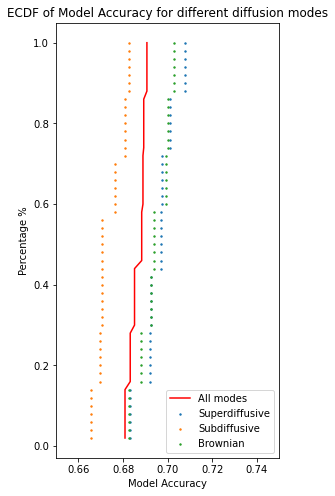

In [73]:
plt.figure(figsize=(4,8))
conf_x, conf_y = ecdf(np.array(confined_acc_list))
dir_x, dir_y = ecdf(np.array(directed_acc_list))
norm_x, norm_y = ecdf(np.array(normal_acc_list))
all_x, all_y = ecdf(np.array(all_acc_list))
#hind_x, hind_y = ecdf(np.array(hindered_acc_list))
#imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
plt.scatter(dir_x, dir_y, label='Superdiffusive', s=2)
plt.scatter(conf_x, conf_y, label='Subdiffusive', s=2)
plt.scatter(norm_x, norm_y, label='Brownian', s=2)
plt.plot(all_x, all_y, label='All modes', c='r')
#plt.scatter(hind_x, hind_y, label='hindered', s=2)
#plt.scatter(imm_x, imm_y, label='immobilized', s=2)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')
plt.xlim([.65, .75])

In [111]:
treatment_dict = {'confined_acc': np.array(confined_acc_list),
                  'directed_acc': np.array(directed_acc_list),
                  'normal_acc': np.array(normal_acc_list),
                  #'hindered_acc': np.array(hindered_acc_list),
                  #'#immobilized_acc': np.array(immobilized_acc_list),
                  'all_modes_acc': np.array(all_acc_list)
                    }
treatment_result_df = pd.DataFrame.from_dict(treatment_dict)
treatment_result_df.to_csv('treatment_accuracies_v4.csv', index=False)

In [18]:
treatment_result_df = pd.read_csv('treatment_accuracies_v4.csv')

In [113]:
treatment_result_df

,confined_acc,directed_acc,normal_acc,all_modes_acc
0,0.680212,0.693840,0.694781,0.676078
1,0.665675,0.697925,0.693586,0.687744
2,0.672581,0.697616,0.679211,0.676712
3,0.680857,0.697176,0.693905,0.685112
4,0.665418,0.697281,0.702873,0.680844
5,0.670760,0.682907,0.692596,0.689237
6,0.670449,0.700901,0.682665,0.690659
7,0.682708,0.707764,0.687872,0.688323
8,0.669724,0.692382,0.700323,0.688889
9,0.676490,0.691827,0.699172,0.683185


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

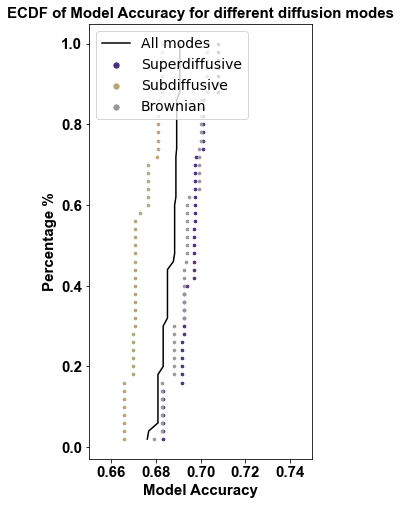

In [20]:
plt.figure(figsize=(4,8))
conf_x, conf_y = ecdf(np.array(treatment_result_df['confined_acc']))
dir_x, dir_y = ecdf(np.array(treatment_result_df['directed_acc']))
norm_x, norm_y = ecdf(np.array(treatment_result_df['normal_acc']))
all_x, all_y = ecdf(np.array(treatment_result_df['all_modes_acc']))
#hind_x, hind_y = ecdf(np.array(hindered_acc_list))
#imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
#no_imm_x, no_imm_y = ecdf(np.array(no_imm_acc))
plt.scatter(dir_x, dir_y, label='Superdiffusive', s=7, c='#4b2e83')
plt.scatter(conf_x, conf_y, label='Subdiffusive', s=7, c='#b7a57a')
plt.scatter(norm_x, norm_y, label='Brownian', s=7, c='#999999')
plt.plot(all_x, all_y, label='All modes', c='k')
#plt.scatter(hind_x, hind_y, label='hindered', s=2)
#plt.scatter(imm_x, imm_y, label='immobilized', s=2)
#plt.scatter(no_imm_x, no_imm_y, label='no immobilized points', s=0.5)
plt.xlim([0.65, 0.75])
plt.legend(loc='upper left', markerscale=2.0, fontsize=14)
plt.xlabel('Model Accuracy', fontsize=15, fontname='Arial', fontweight='bold')
plt.ylabel('Percentage %', fontsize=15, fontname='Arial', fontweight='bold')
plt.title('ECDF of Model Accuracy for different diffusion modes', fontsize=15, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')

In [60]:
treatment_result_df.head()

,confined_acc,directed_acc,normal_acc,hindered_acc,immobilized_acc,all_modes_acc
0,0.685660,0.685660,0.695200,0.667531,0.658712,0.682273
1,0.688666,0.688666,0.703626,0.677687,0.660140,0.670110
2,0.678152,0.678152,0.692836,0.655771,0.664185,0.677816
3,0.694224,0.694224,0.693254,0.675558,0.667732,0.694955
4,0.676487,0.676487,0.679693,0.688088,0.661531,0.682044


In [38]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'binary:hinge',
         #'num_class': 2,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "logloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [36]:
dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, target=target)
#(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(X_train=X_train, y_train=X_train['encoded_target'], features=feature_list, init_params=param, metrics=['error', 'logloss', 'auc'])

Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994


In [75]:
print(best_param)
print(best_boost_rounds)

{'max_depth': 2, 'eta': 0.005, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 5, 'subsample': 0.15, 'colsample_bytree': 0.8, 'eval_metric': 'mlogloss'}
1726


In [30]:
best_boost_rounds = 57
best_param = {'max_depth': 5, 'eta': 0.05, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'binary:logitraw', 'silent': 'True', 'gamma': 2, 'subsample': 0.15, 'colsample_bytree': 0.8, 'eval_metric': 'error'}

In [39]:
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds, verbose=True)


[0]	train-logloss:18.3635	eval-logloss:18.6224
[1]	train-logloss:18.3635	eval-logloss:18.6224
[2]	train-logloss:18.3635	eval-logloss:18.6224
[3]	train-logloss:18.3635	eval-logloss:18.6224
[4]	train-logloss:18.3635	eval-logloss:18.6224
[5]	train-logloss:18.3635	eval-logloss:18.6224
[6]	train-logloss:18.3635	eval-logloss:18.6224
[7]	train-logloss:18.3635	eval-logloss:18.6224
[8]	train-logloss:18.3635	eval-logloss:18.6224
[9]	train-logloss:18.3635	eval-logloss:18.6224
[10]	train-logloss:18.3635	eval-logloss:18.6224
[11]	train-logloss:18.3635	eval-logloss:18.6224
[12]	train-logloss:18.3635	eval-logloss:18.6224
[13]	train-logloss:18.3635	eval-logloss:18.6224
[14]	train-logloss:18.3635	eval-logloss:18.6224
[15]	train-logloss:18.3635	eval-logloss:18.6224
[16]	train-logloss:18.3635	eval-logloss:18.6224
[17]	train-logloss:18.3635	eval-logloss:18.6224
[18]	train-logloss:18.3635	eval-logloss:18.6224
[19]	train-logloss:18.3635	eval-logloss:18.6224
[20]	train-logloss:18.3635	eval-logloss:18.6224
[2

In [93]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

       ChABC     0.7155    0.6777    0.6961      3701
          NT     0.6764    0.7144    0.6949      3491

    accuracy                         0.6955      7192
   macro avg     0.6960    0.6960    0.6955      7192
weighted avg     0.6966    0.6955    0.6955      7192



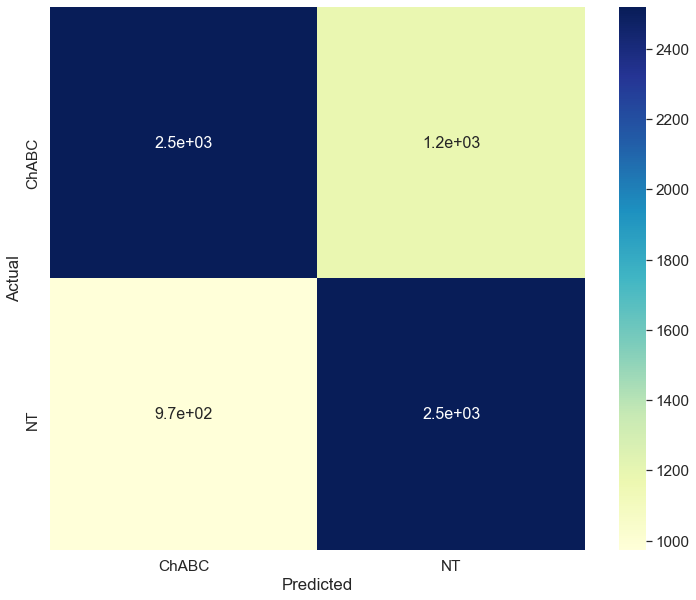

In [89]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

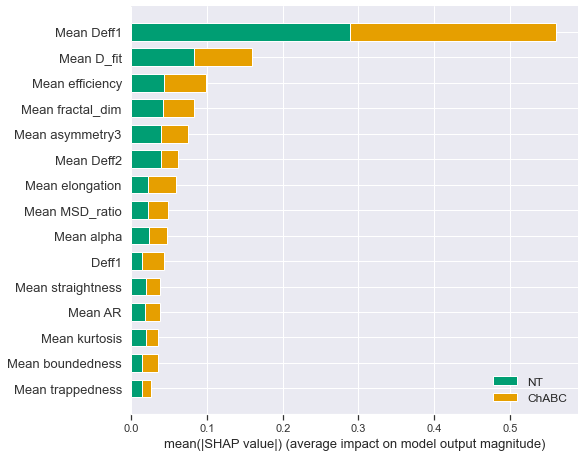

In [94]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
#c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

In [97]:
best_param_alldata = {'max_depth': 5, 'eta': 0.05, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 2, 'silent': 'True', 'gamma': 2.0, 'subsample': 0.15, 'colsample_bytree': 0.8, 'eval_metric': 'mlogloss'}
best_boost_rounds_alldata = 57

In [105]:
#directed_acc_list = []
all_acc_list = []
#hindered_acc_list = []
#immobilized_acc_list = []
for i in range(50):
    print(i)
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(best_param_alldata, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=57, verbose=False)
    all_acc_list.append(acc)

    # dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(directed_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds, verbose=False)
    # directed_acc_list.append(acc)

0
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6829064296915839
1
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6825477967487987
2
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.688470770968653
3
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6814024390243902
4
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6831897291545089
5
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6871552950154358
6
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6851673984632273
7
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.68

In [102]:
all_acc_list

[]

(0.65, 0.75)

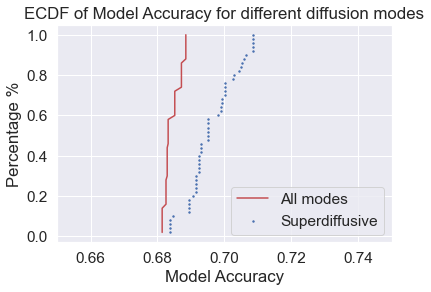

In [107]:
plt.figure()#figsize=(4,8))
dir_x, dir_y = ecdf(np.array(directed_acc_list))
all_x, all_y = ecdf(np.array(all_acc_list))
#hind_x, hind_y = ecdf(np.array(hindered_acc_list))
#imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
plt.scatter(dir_x, dir_y, label='Superdiffusive', s=2)
plt.plot(all_x, all_y, label='All modes', c='r')
#plt.scatter(hind_x, hind_y, label='hindered', s=2)
#plt.scatter(imm_x, imm_y, label='immobilized', s=2)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')
plt.xlim([.65, .75])